In [67]:
import warnings
warnings.filterwarnings("ignore")

# Import libraries and read data

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_validate

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score, f1_score, 
                             log_loss, roc_curve, confusion_matrix, precision_score, recall_score)

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.externals import joblib
from math import sin, cos, sqrt, atan2, radians
import random
import statsmodels.api as sm
from sklearn.svm import SVC 
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss

In [69]:
mm_data = pd.read_csv(r'C:\Users\11654\Desktop\NCAA_Tourney_2002_2019_update.csv')
mm_data2 = pd.read_csv(r'C:\Users\11654\Desktop\NCAA_Tourney_2002_2019_update.csv')
mm_data_co = pd.read_csv(r'C:\Users\11654\Desktop\MarchMadness\Edited NCAA_Tourney_2002_2019.csv')
test = pd.read_csv(r'C:\Users\11654\Desktop\MarchMadness\test.csv')
test_ori = pd.read_csv(r'C:\Users\11654\Desktop\NCAA_Tourney_2020_update.csv')
train = pd.read_csv(r'C:\Users\11654\Desktop\MarchMadness\train.csv')
train_ori = pd.read_csv(r'C:\Users\11654\Desktop\NCAA_Tourney_2002_2019_update.csv')


In [70]:
mm_data3 = pd.read_csv(r'C:\Users\11654\Desktop\NCAA_Tourney_2020_update.csv')

In [71]:
mm_data3.shape
#original dataset has 1167 rows, 104 columns

(2278, 102)

# randomly split data

In [72]:
def split_data(mm_data):
    my_randoms = random.sample(range(len(mm_data)), int(len(mm_data)/2))

    mm_data1 = mm_data[~mm_data.index.isin(my_randoms)]
    mm_data2 = mm_data[mm_data.index.isin(my_randoms)]

    co1=mm_data2.columns.to_list()
    print(len(co1))
    co2=[]
    for i in co1:
        if i[0:5]=='team1':
            i='team2'+i[5:]
        elif i[0:5]=='team2':
            i='team1'+i[5:]
        co2.append(i)
    print(len(co2))

    mm_data2.columns=co2
    mm_data1['result']=1
    mm_data2['result']=0

    mm_data=pd.concat([mm_data1,mm_data2]).reset_index(drop=True)
    return mm_data,my_randoms

# data preproccessing

In [73]:
def distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [74]:
def data_preproccess(mm_data,mm_data_co):
    #E(W%) = points scored^11.5 / (points scored^11.5+points allowed^11.5)
    #P(W) = (A - A B) / (A + B - 2A*B)
    #create a new variable - team1_log5
    mm_data['exp_win1'] = (mm_data['team1_adjoe']**11.5)/ ((mm_data['team1_adjde']**11.5)+(mm_data['team1_adjoe']**11.5))
    mm_data['exp_win2'] = (mm_data['team2_adjoe']**11.5)/ ((mm_data['team2_adjde']**11.5)+(mm_data['team2_adjoe']**11.5))
    mm_data['team1_log5'] = (mm_data['exp_win1'] - (mm_data['exp_win1']*mm_data['exp_win2']))/ (mm_data['exp_win1']+mm_data['exp_win2']-(2*mm_data['exp_win1']*mm_data['exp_win2']))

    #create a new variable - difference between distance from host to team1 and distance from host to team2
    #positive means team 1 is further from host location than team 2
    mm_data['dist1'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
    mm_data['dist2'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)
    mm_data['diff_dist'] = mm_data['dist1'] - mm_data['dist2']

    columns=mm_data_co.columns.to_list()
    co3=['exp_win1','exp_win2','team1_log5','dist1','dist2','diff_dist','result']
    columns=columns+co3

    mm_data=mm_data.loc[:,columns]
    
    
    #create dummy variables for regions and coaches
    mm_data=pd.concat([mm_data,pd.get_dummies(mm_data.loc[:,['team1_region','team2_region','team1_coach_id','team2_coach_id']])],axis=1)
    mm_data=mm_data.drop(['team1_region','team2_region','team1_coach_id','team2_coach_id'], axis=1)

    list1=['team1_ap_final','team1_ap_preseason','team2_ap_final','team2_ap_preseason']
    #fill missing values for ranks over 25 to 26 
    for i in list1:
        mm_data[i]=mm_data[i].fillna(value=26)
    list2=list(mm_data.columns)
    #fill missing values for dist to 0
    for i in list2:
        mm_data[i]=mm_data[i].fillna(value=0)
    
    return mm_data

In [75]:
mm_data,ran=split_data(mm_data)

104
104


In [76]:
mm_data=data_preproccess(mm_data,mm_data_co)
mm_test=data_preproccess(test_ori,mm_data_co)

In [77]:
a = list(mm_data.columns)
b = list(mm_test.columns)
c = []
d=[]
for i in a:
    if i in b:
        continue
    else:
        c.append(i)
for i in c:
    mm_test[i] = 0

for i in b:
    if i in a:
        continue
    else:
        d.append(i)
for i in d:
    mm_data[i] = 0
    
    
#fill missing values for dist to 0
for i in list(mm_data.columns):
    mm_data[i]=mm_data[i].fillna(value=0)
for i in list(mm_test.columns):
    mm_test[i]=mm_test[i].fillna(value=0)

# Modelling

In [86]:
# set machine labels and models used later
ml_labels = ["LR_l2",
             "RF",
             "XGB",
             "SVM",
             "KNN"
            ]

models = [LogisticRegression(penalty= 'l2',solver = 'saga'),
          RandomForestClassifier(n_estimators=1000,max_depth=25,min_samples_leaf=3),
          XGBClassifier(),
          SVC(probability=True),
          KNeighborsClassifier()
         ]

In [87]:
def model_predict(model,features_train,features_test,labels_train,labels_test):
    '''
    Make prediction on machine learning
    input:  model -- the model used to predict
            features_train -- the training data(x_train)
            features_test -- the testing data(x_test)
            labels_train -- the training labels(y_train)
            labels_test -- the testing labels(y_test)
            
    return: the predicted values and probabilities
    '''
    ml=model
    ml.fit(features_train,labels_train.ravel())
    
    pred2=model.predict(features_test)
    prob2 = model.predict_proba(features_test)
    pred1=model.predict(features_train)
    prob1 = model.predict_proba(features_train)
    #print(classification_report(labels_test,pred))
    return pred1,prob1,pred2,prob2,ml

def roc_get_par(test,prob):
    '''
    get false positive and true positive score
    input:  test -- the true values
            prob -- predicted probilities
            
    return: a FP and TP rate list
    '''
    fpr, tpr, _  = roc_curve(test, prob[:,1])
    return [ fpr, tpr] 

def training(traning,testing,target,models = models):
    '''
    print out the information of the input dataframe, including a plot of target values and descriptions   
    input:  training -- the training data
            testing -- the testing data
            target -- the name of the target
            var_group -- the names of feature groups (list)
            combine_var -- the names of feature groups and ml models(list)
            models -- models to use in the training        
    return: the result of prediction and the pars for ROC curve
    '''
    par = []
 
 
    md=[]
    logloss = []
    acc_v = []
    acc_t1 = []
    acc_t2=[]
    au_v = []
    au_t1 = []
    au_t2 = []
    precision1 = []
    precision2 = []
    recall1 = []
    recall2 = []
    pred_train=[]
    prob_train=[]
    pred_test=[]
    prob_test=[]
    for model in models:
#             cv = cross_validate(model, 
#                                 traning.loc[:,[i for i in traning.columns.to_list() if i != target]], 
#                                 traning[target], 
#                                 cv=5,
#                                 scoring=('accuracy', 'roc_auc'),
#                                 return_train_score=True)
#             acc_v.append(cv['test_accuracy'].mean())
#             au_v.append(cv['test_roc_auc'].mean())
 
 
            pred1,prob1,pred2,prob2,model_fit = model_predict(model,
                                      traning.loc[:,[i for i in traning.columns.to_list() if i != target]],
                                      testing.loc[:,[i for i in traning.columns.to_list() if i != target]],
                                      traning[target],
                                      testing[target])        
 
            r2= roc_get_par(testing[target],prob2)
            r1= roc_get_par(traning[target],prob1)
 
            au_t2.append(auc(r2[0],r2[1]))
            au_t1.append(auc(r1[0],r1[1]))
            acc_t2.append(accuracy_score(testing[target],pred2))
            acc_t1.append(accuracy_score(traning[target],pred1))
            precision1.append(precision_score(traning[target],pred1))
            precision2.append(precision_score(testing[target],pred2))
            recall1.append(recall_score(traning[target],pred1))
            recall2.append(recall_score(testing[target],pred2))
            par.append(r2)
            pred_train.append(pred1)
            pred_test.append(pred2)
            prob_train.append(prob1[:,1])
            prob_test.append(prob2[:,1])
            md.append(model_fit)
            logloss.append(log_loss(testing[target],pred2))
 
            print('--------------------------')
    result_df = {'variable_model': models,
#                 'cross_v_accuracy':acc_v,
                 'train_accuracy':acc_t1,
                 'test_accuracy':acc_t2,
#                 'cross_v_auc':au_v,
                 'train_auc':au_t1,
                 'test_auc':au_t2,
                 'train_precision':precision1,
                 'test_precision':precision2,
                 'train_recall':recall1,
                 'test_recall':recall2,
                 'log_loss':logloss
                }
 
    return pd.DataFrame(result_df), par, md

model_names = ["Logistic Regression",
               "Random Forest",              
               "XgBoost",
               "SVM",
               "KNN"]

def roc_plt(par,model_names = model_names):
    '''
    plot the roc curve
    input:  par -- pars calculated from prediction
            group_name --  the names of feature groups 
            model_names -- the name of the models used
    return: NA
    '''            
    plt.figure(figsize=(15, 10))
    plt.plot([0, 1], [0, 1], 'k--')    
    n=0

    for i in range(5):
        plt.plot(par[i][0], 
                 par[i][1], 
                 label=model_names[i])

    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.title(' ROC curve')
    plt.legend(loc='best')
    plt.show()

In [98]:
# Splitting the dataset into the Training set and Test set (70%:30% partition)
mm_data_to_train, mm_data_to_test = train_test_split(mm_data,test_size=0.3)

In [99]:
result_def_all, par_def_all, model_fit_def= training(mm_data_to_train, mm_data_to_test, 'result')

--------------------------
--------------------------
--------------------------
--------------------------
--------------------------


In [111]:
result_def_all.sort_values('test_auc',ascending = False).to_csv('Performance.csv')

In [117]:
#from sklearn.metrics import plot_confusion_matrix

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (E:\Anaconda\lib\site-packages\sklearn\metrics\__init__.py)

In [124]:
#confusion_matrix(mm_data_to_test.result,model_fit_def[1].predict(mm_data_to_test.drop('result',axis=1)))

array([[138,  38],
       [ 51, 124]], dtype=int64)

In [125]:
#from joblib import dump, load
#dump(model_fit_def[1],'rf.joblib')

['rf.joblib']

In [127]:
mm_data_to_train.to_csv('train.csv')

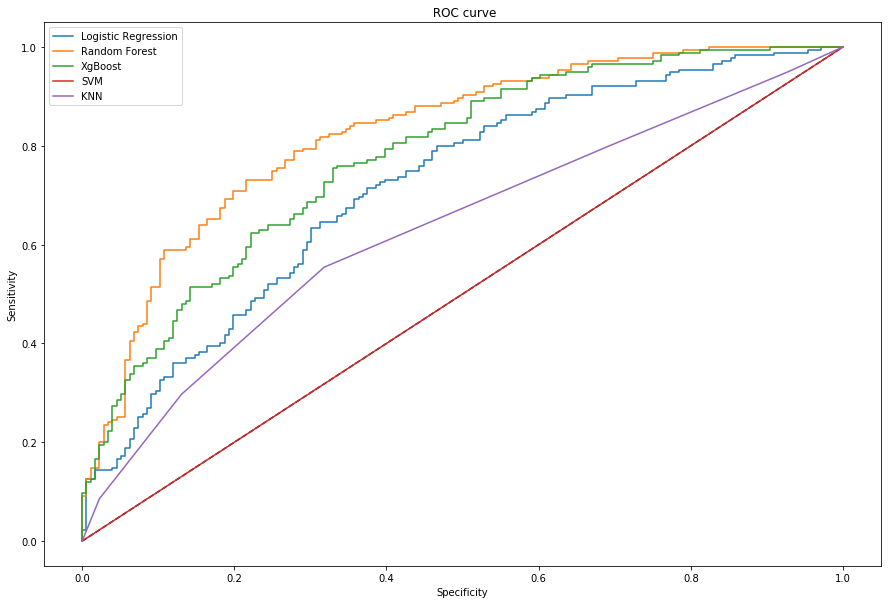

In [101]:
roc_plt(par_def_all)
#XGBoost performs the best

In [102]:
prob_win=model_fit_def[2].predict_proba(mm_data[mm_data.result==1].loc[:,[i for i in mm_data.columns.to_list() if i != 'result']])
prob_lose=model_fit_def[2].predict_proba(mm_data[mm_data.result==0].loc[:,[i for i in mm_data.columns.to_list() if i != 'result']])

In [103]:
prob_win[:,1].mean()

0.7257396

In [104]:
prob_lose[:,1].mean()

0.2589618

In [105]:
mm_test=mm_test.drop('result',axis=1)

In [106]:
co=mm_data.drop('result',axis=1).columns.to_list()

In [107]:
mm_test[co]

,team1_seed,team2_seed,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,...,team2_coach_id_lavall-jordan-1,team2_coach_id_mark-pope-1,team2_coach_id_matt-langel-1,team2_coach_id_michael-huger-1,team2_coach_id_mike-rhoades-1,team2_coach_id_mitch-henderson-1,team2_coach_id_scott-nagy-1,team2_coach_id_steve-pikiell-1,team2_coach_id_travis-decuire-1,team2_coach_id_willie-jones-1
0,1,2,8.0,8.0,4.0,4.0,0.0,0.0,344.0,212,...,0,0,0,0,0,0,0,0,0,0
1,1,3,8.0,8.0,4.0,4.0,0.0,0.0,344.0,212,...,0,0,0,0,0,0,0,0,0,0
2,1,4,8.0,8.0,4.0,4.0,0.0,0.0,344.0,212,...,0,0,0,0,0,0,0,0,0,0
3,1,5,8.0,8.0,4.0,4.0,0.0,0.0,344.0,212,...,0,0,0,0,0,0,0,0,0,0
4,1,6,8.0,8.0,4.0,4.0,0.0,0.0,344.0,212,...,0,0,0,0,0,0,0,0,0,0
5,1,7,8.0,8.0,4.0,4.0,0.0,0.0,344.0,212,...,0,0,0,0,0,0,0,0,0,0
6,1,8,8.0,8.0,4.0,4.0,0.0,0.0,344.0,212,...,0,0,0,0,0,0,0,0,0,0
7,1,9,8.0,8.0,4.0,4.0,0.0,0.0,344.0,212,...,0,0,0,0,1,0,0,0,0,0
8,1,10,8.0,8.0,4.0,4.0,0.0,0.0,344.0,212,...,0,0,0,0,0,0,0,0,0,0
9,1,11,8.0,8.0,4.0,4.0,0.0,0.0,344.0,212,...,0,0,0,0,0,0,0,0,0,0


In [108]:
prob=model_fit_def[1].predict_proba(mm_test[co])

In [109]:
mm_test['prob']=prob[:,1]

In [110]:
mm_test.to_csv('result.csv', index = False)